##### Imports

In [1]:
import sys
from pathlib import Path
import warnings

import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

import pickle
from pathlib import Path
from scr.dataset import *
from scr.game import *
import gc
from scr.utils import print_scenarios


from pathlib import Path
import random
from collections import Counter, defaultdict
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset
from scr.feature_engineering import \
    calculate_char_frequencies, calculate_word_frequencies
from scr.utils import read_words, save_words_to_file

import sys
# Custom library paths
sys.path.extend(['../', './scr'])

from scr.utils import set_seed
from scr.utils import read_words

set_seed(42)

import torch
import torch.nn as nn
from pathlib import Path
import random

torch.set_float32_matmul_precision('medium')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Read and Shuffle Word List
word_list = read_words('data/words_250000_train.txt') # , limit=10000)
# word_list = read_words('data/250k.txt', limit=10000)
random.shuffle(word_list)

In [2]:
# # Parameters
# NUM_STRATIFIED_SAMPLES = None  # This will be overwritten by Papermill
# base_dataset_dir = None        # This will be overwritten by Papermill

# print("NUM_STRATIFIED_SAMPLES:", NUM_STRATIFIED_SAMPLES)
# print("base_dataset_dir:", base_dataset_dir)

# # Import necessary library
# from pathlib import Path

# # Validate if parameters are provided
# if NUM_STRATIFIED_SAMPLES is None or base_dataset_dir is None:
#     raise ValueError("NUM_STRATIFIED_SAMPLES and base_dataset_dir must be provided.")

# # Define the base directory on the specified drive
# base_dataset_dir = Path(base_dataset_dir)

# # Ensuring the directory exists
# base_dataset_dir.mkdir(parents=True, exist_ok=True)

# # Create a subdirectory for pickle files
# pkls_dir = base_dataset_dir / 'pkl'
# pkls_dir.mkdir(parents=True, exist_ok=True)

In [3]:
from pathlib import Path

NUM_STRATIFIED_SAMPLES = 500

# Define the base directory
base_dataset_dir = Path(f'./dataset/{NUM_STRATIFIED_SAMPLES}')
# base_dataset_dir = Path(f"/media/sayem/510B93E12554BBD1/dataset/{NUM_STRATIFIED_SAMPLES}")

# Ensuring the base directory and 'pkl' subdirectory exist
base_dataset_dir.mkdir(parents=True, exist_ok=True)
pkls_dir = base_dataset_dir / 'pkl'
pkls_dir.mkdir(parents=True, exist_ok=True)


In [4]:
# Splitting Dataset Function
def split_dataset(word_list, train_ratio=0.7, val_ratio=0.15):
    total_words = len(word_list)
    train_size = int(total_words * train_ratio)
    val_size = int(total_words * val_ratio)
    random.shuffle(word_list)
    return word_list[:train_size], word_list[train_size:train_size + val_size], \
        word_list[train_size + val_size:]


# Splitting the word list
train_words, val_words, test_words = split_dataset(word_list)

# Save split datasets to files
save_words_to_file(train_words, base_dataset_dir / 'train_words.txt')
save_words_to_file(val_words, base_dataset_dir / 'val_words.txt')
save_words_to_file(test_words, base_dataset_dir / 'test_words.txt')

# Calculate Frequencies and Max Word Length
word_frequencies = calculate_word_frequencies(train_words)
char_frequency = calculate_char_frequencies(train_words)
max_word_length = max(len(word) for word in train_words)

In [5]:
len(train_words)

159110

In [6]:
## we are taking starified samples from train_words

from scr.custom_sampler import \
    stratified_sample_by_length_and_frequency, \
        stratified_sample_by_length

print(f'Number of Statrified samples: {NUM_STRATIFIED_SAMPLES}')

# sampled_words_by_length_and_frequency \
#     = stratified_sample_by_length_and_frequency(train_words, \
#     word_frequencies, \
#     NUM_STRATIFIED_SAMPLES)

Number of Statrified samples: 500


In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def analyze_hangman_sample_practicality(original_word_list, stratified_sampling_method, num_samples):
    # Generate a stratified sample
    stratified_sample = stratified_sampling_method(original_word_list, num_samples)

    # Analyze and plot word length distributions
    plot_stratified_sampling_analysis(original_word_list, stratified_sample)

    # Get word length distributions
    original_lengths, sampled_lengths = get_length_distributions(original_word_list, stratified_sample)

    # Evaluate representation of word lengths
    representation_evaluation = {length: sampled_lengths.get(length, 0) / original_lengths.get(length, 1)
                                 for length in original_lengths}

    # Plotting the quality of sampling
    plt.figure(figsize=(10, 5))
    plt.bar(representation_evaluation.keys(), \
        representation_evaluation.values(), color='purple', alpha=0.7)
    plt.xlabel('Word Length')
    plt.ylabel('Representation Ratio')
    plt.title('Quality of Sampling Analysis')
    plt.axhline(y=1, color='r', linestyle='--')
    plt.show()

    # Check for unique word inclusion
    unique_inclusion = len(set(stratified_sample)) == len(set(original_word_list))

    return representation_evaluation, unique_inclusion

def plot_stratified_sampling_analysis(original_word_list, stratified_sampled_word_list):
    original_lengths = Counter([len(word) for word in original_word_list])
    sampled_lengths = Counter([len(word) for word in stratified_sampled_word_list])

    unique_lengths = sorted(set(original_lengths.keys()) | set(sampled_lengths.keys()))
    original_counts = [original_lengths[length] for length in unique_lengths]
    sampled_counts = [sampled_lengths[length] for length in unique_lengths]

    original_counts_normalized = np.array(original_counts) / sum(original_counts)
    sampled_counts_normalized = np.array(sampled_counts) / sum(sampled_counts)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(unique_lengths, original_counts_normalized, color='blue', alpha=0.7)
    plt.title('Normalized Original Word Length Distribution')
    plt.xlabel('Word Length')
    plt.ylabel('Normalized Frequency')

    plt.subplot(1, 2, 2)
    plt.bar(unique_lengths, sampled_counts_normalized, color='green', alpha=0.7)
    plt.title('Normalized Stratified Sample Word Length Distribution')
    plt.xlabel('Word Length')
    plt.ylabel('Normalized Frequency')
    plt.tight_layout()
    plt.show()

def get_length_distributions(original_word_list, stratified_sampled_word_list):
    original_lengths = Counter([len(word) for word in original_word_list])
    sampled_lengths = Counter([len(word) for word in stratified_sampled_word_list])
    return original_lengths, sampled_lengths


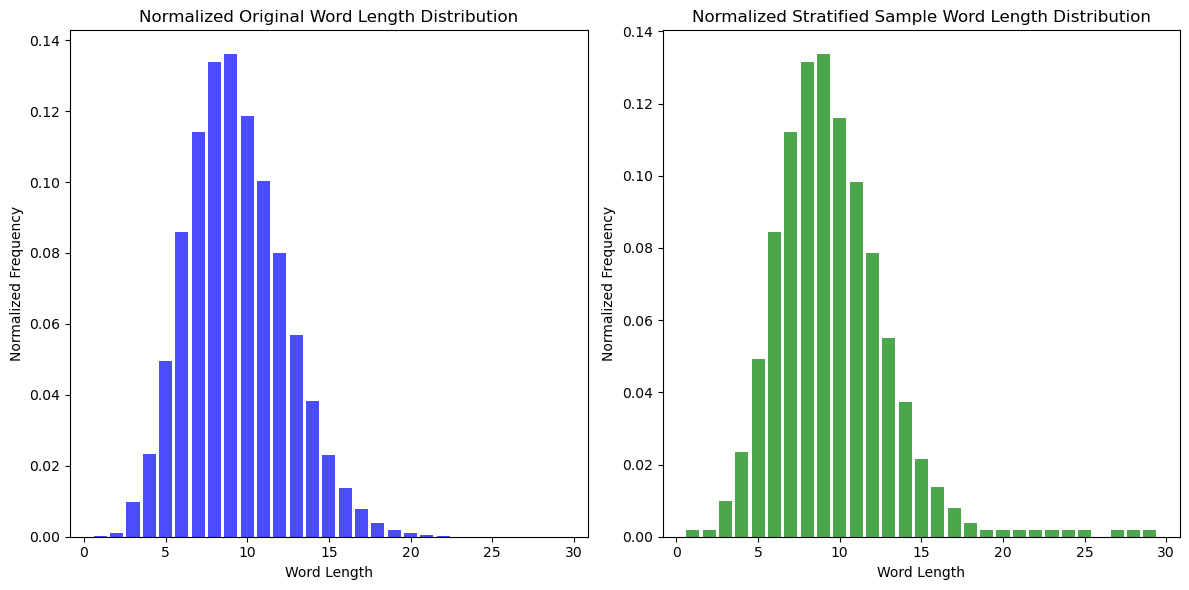

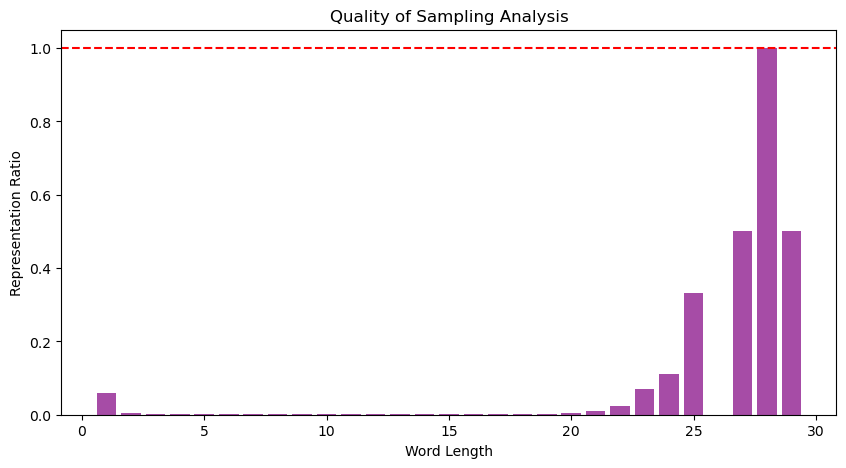

In [8]:
representation_evaluation, unique_inclusion = analyze_hangman_sample_practicality(
    word_list, 
    stratified_sample_by_length, 
    NUM_STRATIFIED_SAMPLES
)

In [9]:
sampled_words_by_length = stratified_sample_by_length(word_list, \
    NUM_STRATIFIED_SAMPLES)

In [10]:
unique_inclusion

False

In [11]:
# sampled_words_by_length_and_frequency \
#     = stratified_sample_by_length_and_frequency(train_words, \
#     word_frequencies, \
#     NUM_STRATIFIED_SAMPLES)

##### Game Simulation: Data Reading and Feature Engineering

In [12]:
def count_repetitive_characters(word):
    char_count = {}
    for char in word:
        char_count[char] = char_count.get(char, 0) + 1
    return sum(1 for count in char_count.values() if count > 1)

def adaptive_mask_prob_and_variants(word):
    word_length = len(word)
    unique_char_count = len(set(word))
    repetitive_char_count = count_repetitive_characters(word)

    # Lower mask probability for longer and more unique words
    if word_length <= 5:
        mask_prob = 0.8 if repetitive_char_count > (word_length / 2) else 0.9
    
    elif word_length <= 8:
        mask_prob = 0.6 if unique_char_count > 4 else 0.7
    
    else:
        mask_prob = 0.4 if unique_char_count > 6 else 0.5

    # Adjust max variants based on the complexity of the word
    if unique_char_count <= 3 or repetitive_char_count > (word_length / 2):
        max_variants = max(5, word_length)
    
    elif unique_char_count <= 6:
        max_variants = max(10, word_length)
    
    else:
        max_variants = min(15, word_length)

    return mask_prob, max_variants


In [13]:
def modified_adaptive_mask_prob_and_variants(word, length_distribution):
    word_length = len(word)
    unique_char_count = len(set(word))
    repetitive_char_count = count_repetitive_characters(word)

    # Determine average word length from the distribution
    avg_word_length = sum(length * count for length, count in \
        length_distribution.items()) / sum(length_distribution.values())

    # Adjust the mask probability and max variants based on the average word length
    if word_length <= avg_word_length:
        mask_prob = 0.8 if repetitive_char_count > (word_length / 2) else 0.9
        max_variants = max(5, word_length)
    else:
        mask_prob = 0.6 if unique_char_count > 4 else 0.7
        max_variants = max(10, word_length)

    return mask_prob, max_variants


In [14]:
# Get the word length distributions for further analysis
original_lengths_distribution, sampled_lengths_distribution \
    = get_length_distributions(word_list, sampled_words_by_length)


word = "noon"
mask_prob, max_variants \
    = modified_adaptive_mask_prob_and_variants(word, sampled_lengths_distribution)

mask_prob

0.9

In [15]:
word = "noon"
mask_prob, max_variants = adaptive_mask_prob_and_variants(word)

mask_prob

0.9

In [16]:
max_variants

5

##### Game State Simulation

In [17]:
from scr.game import simulate_game_progress, play_game_with_a_word, process_word

# Example word and initial state
# Example usage
word = "mississippi"
# word = "cat"
# mask_prob, max_variants = adaptive_mask_prob_and_variants(word)


mask_prob, max_variants \
    = modified_adaptive_mask_prob_and_variants(word, sampled_lengths_distribution)

initial_states = process_word(word, mask_prob=mask_prob, \
    max_variants=max_variants)

# Print generated initial states
print("Generated Initial States:")
for initial_state in initial_states:
    # Simulate the game
    print(initial_state)
    print(f"For initial state: {initial_state}")
    won, game_progress = simulate_game_progress(
        model=None,  # Assuming model is not used in this example
        word=word, 
        initial_state=initial_state, 
        char_frequency={},  # Assuming char_frequency is not used in this example
        max_word_length=len(word), 
        device=None,  # Assuming device is not used in this example
        max_attempts=6, 
        normalize=True,
        difficulty="medium", 
        outcome_preference='win'
    )

    # Display game progress
    for step in game_progress:
        print(f"Guessed: '{step[0]}', New State: '{step[1]}', Correct: {step[2]}")

        # break

    # break

    # print("Game Result:", "Won" if won else "Lost")

Generated Initial States:
___________
For initial state: ___________
Guessed: 's', New State: '__ss_ss____', Correct: True
Guessed: 'h', New State: '__ss_ss____', Correct: False
Guessed: 'e', New State: '__ss_ss____', Correct: False
Guessed: 'p', New State: '__ss_ss_pp_', Correct: True
Guessed: 'f', New State: '__ss_ss_pp_', Correct: False
Guessed: 'u', New State: '__ss_ss_pp_', Correct: False
Guessed: 'i', New State: '_ississippi', Correct: True
Guessed: 'v', New State: '_ississippi', Correct: False
Guessed: 'm', New State: 'mississippi', Correct: True
m_ss_ss____
For initial state: m_ss_ss____
Guessed: 'n', New State: 'm_ss_ss____', Correct: False
Guessed: 'i', New State: 'mississi__i', Correct: True
Guessed: 'l', New State: 'mississi__i', Correct: False
Guessed: 'k', New State: 'mississi__i', Correct: False
Guessed: 'j', New State: 'mississi__i', Correct: False
Guessed: 'b', New State: 'mississi__i', Correct: False
Guessed: 'p', New State: 'mississippi', Correct: True
_ississi__i
Fo

In [18]:
len(initial_states)

11

In [19]:
initial_states

['___________',
 'm_ss_ss____',
 '_ississi__i',
 '________pp_',
 'm__________',
 '_i__i__ippi',
 '__ss_ss____',
 '_i__i__i__i',
 'mi__i__i__i',
 '__ss_ss_pp_',
 'm_______pp_']

##### Dataset Generation

In [20]:
from scr.custom_sampler import stratified_sample_by_length_and_frequency

# NUM_STRATIFIED_SAMPLES = 1000
# Main loop
iteration = 0

sampled_words = stratified_sample_by_length_and_frequency(train_words, \
    word_frequencies, \
    NUM_STRATIFIED_SAMPLES)

original_lengths_distribution, sampled_lengths_distribution \
    = get_length_distributions(word_list, sampled_words_by_length)

print(f'Number words for state generation: {len(sampled_words)}')

Number words for state generation: 509


In [21]:
# ### one way to generate the dataset

for word in tqdm(sampled_words, miniters=2, leave=False, mininterval=2.0): 
    
    all_scenarios = []
    
    game_states = process_word_for_six_states(word)

    for state_name, initial_state in game_states.items():
        for difficulty in ["easy", "medium", "hard"]:
            for outcome in ["win", "lose"]:
                won, game_progress = simulate_game_progress(
                    model=None, 
                    word=word, 
                    initial_state=initial_state, 
                    char_frequency=char_frequency, 
                    max_word_length=max_word_length, 
                    device=device, 
                    max_attempts=6, 
                    normalize=True, 
                    difficulty=difficulty, 
                    outcome_preference=outcome
                )

                scenario = {
                    'word': word, 
                    'state': state_name,  # Added 'state' key
                    'difficulty': difficulty,
                    'outcome': outcome, 
                    'initial_state': initial_state,
                    'data': (won, game_progress)
                }
                all_scenarios.append(scenario)

    #             break
    #         break
    #     break
    # break

    # Create a directory for the current strarified samples
    
    current_batch_dir = pkls_dir / str(iteration)
    current_batch_dir.mkdir(parents=True, exist_ok=True)

    # print(all_scenarios)

    # print(current_batch_dir)

    for scenario in all_scenarios:
        try:
            game_states = [scenario['data']]
            
            difficulty = scenario['difficulty']
            outcome = scenario['outcome']
            state = scenario['state']
            initial_state = scenario['initial_state']  # This should be the correct scope
            file_path \
                = current_batch_dir \
                    / f"{word}-from-{initial_state}-{state}-{difficulty}-{outcome}.pkl"

            # print(f"Saving scenario for {word}: {file_path}")

            with open(file_path, 'wb') as file:
                pickle.dump(game_states, file)

            # print(f"Saved {file_path}")

        except Exception as e:
            print(f"Error saving {file_path}: {e}")

    # Clear memory
    del all_scenarios # , sampled_scenarios

    # Manual garbage collection
    gc.collect()

    # train_words = [word for word in train_words if word not in sampled_words]
    # print(len(train_words))
    # print(iteration)
    iteration += 1

In [22]:
pkls_dir

PosixPath('dataset/500/pkl')

##### Reading Checking

In [23]:
import pickle
from pathlib import Path

pkl_list = []

for batch_dir in sorted(pkls_dir.iterdir(), \
    key=lambda x: int(x.name) if x.name.isdigit() else float('inf')):

    if batch_dir.is_dir():
        pkl_files = list(batch_dir.glob("*.pkl"))

        for pkl_file in pkl_files:
            with open(pkl_file, 'rb') as file:
                game_data = pickle.load(file)

                parts = pkl_file.stem.split('-from-')
                word, remaining = parts[0], parts[1]
                remaining_parts = remaining.split('-')
                initial_state = remaining_parts[0]
                state_name = remaining_parts[1]
                difficulty = remaining_parts[2]
                outcome = remaining_parts[3]

                for data in game_data:
                    game_won, guesses = data
                    scenario = {
                        'word': word,
                        'state': state_name,
                        'difficulty': difficulty,
                        'outcome': outcome,
                        'initial_state': initial_state,
                        'data': (game_won, guesses)
                    }
                    pkl_list.append((pkl_file, scenario))

# Example usage
index_to_access = 1000
if index_to_access < len(pkl_list):
    file_path, scenario = pkl_list[index_to_access]
    print(f"Contents of {file_path}:")
    # Assuming print_scenarios is a defined function
    print_scenarios([scenario])
else:
    print(f"No pickle file at index {index_to_access}")


Contents of dataset/500/pkl/13/homeostatic-from-___e_s___ic-nearEnd-easy-lose.pkl:
Word: homeostatic
State: nearEnd
Difficulty: easy
Outcome: lose
Initial_state: ___e_s___ic
  Game Won
  Guessed 'k', State: ___e_s___ic, Correct: False
  Guessed 'a', State: ___e_s_a_ic, Correct: True
  Guessed 'm', State: __me_s_a_ic, Correct: True
  Guessed 'o', State: _omeos_a_ic, Correct: True
  Guessed 'h', State: homeos_a_ic, Correct: True
  Guessed 't', State: homeostatic, Correct: True



In [24]:
# ### one way to generate the dataset

# for word in tqdm(sampled_words, miniters=2, leave=False, mininterval=2.0): 
#     # , miniters=2, leave=False, mininterval=2.0):
#     # print(word)
#     all_scenarios = []
#     # Process the word to get initial masked states
#     # initial_masked_states = process_word(word, mask_prob=0.9, max_variants=10)

#     # mask_prob, max_variants = adaptive_mask_prob_and_variants(word)
#     mask_prob, max_variants \
#         = modified_adaptive_mask_prob_and_variants(word, sampled_lengths_distribution)

#     game_states = process_word(word, mask_prob=mask_prob, \
#         max_variants=max_variants)

#     for initial_state in game_states:
        
#         difficulties = ["easy", "medium", "hard"]
#         outcomes = ["win", "lose"]

#         for difficulty in difficulties:
#             for outcome in outcomes:
#                 # print(f'{word} from initial state: {initial_state}: \
#                 # Difficulty: {difficulty}, Outcome: {outcome}')
#                 won, game_progress = simulate_game_progress(
#                                         model=None, 
#                                         word=word, 
#                                         initial_state=initial_state, 
#                                         char_frequency=char_frequency, 
#                                         max_word_length=max_word_length, 
#                                         device=device, 
#                                         max_attempts=6, 
#                                         normalize=True, 
#                                         difficulty=difficulty, 
#                                         outcome_preference=outcome
#                                     )

#                 # all_scenarios.append({'word': word, 'difficulty': difficulty, \
#                 #     'outcome': outcome, 'data': (won, game_progress)})

#                 all_scenarios.append({
#                             'word': word, 
#                             'difficulty': difficulty,
#                             'outcome': outcome, 
#                             'initial_state': initial_state,  # Added 'initial_state' key
#                             'data': (won, game_progress)
#                         })  # all game state

#     #             break
#     #         break
#     #     break
#     # break


    
#     # Create a directory for the current strarified samples
    
#     current_batch_dir = pkls_dir / str(iteration)
#     current_batch_dir.mkdir(parents=True, exist_ok=True)

#     # print(all_scenarios)

#     # print(current_batch_dir)

#     for scenario in all_scenarios:
#         try:
#             game_states = [scenario['data']]
#             difficulty = scenario['difficulty']
#             outcome = scenario['outcome']
#             initial_state = scenario['initial_state']  # This should be the correct scope
#             file_path = current_batch_dir / f"{word}_from_{initial_state}_{difficulty}_{outcome}.pkl"

#             # print(f"Saving scenario for {word}: {file_path}")

#             with open(file_path, 'wb') as file:
#                 pickle.dump(game_states, file)

#             # print(f"Saved {file_path}")

#         except Exception as e:
#             print(f"Error saving {file_path}: {e}")

#     # Clear memory
#     del all_scenarios # , sampled_scenarios

#     # Manual garbage collection
#     gc.collect()

#     # train_words = [word for word in train_words if word not in sampled_words]
#     # print(len(train_words))
#     # print(iteration)
#     iteration += 1

In [25]:
# pkl_list = []

# # Iterate over all batch directories
# for batch_dir in sorted(pkls_dir.iterdir(), key=lambda x: int(x.name) \
#     if x.name.isdigit() else float('inf')):
#     if batch_dir.is_dir():
#         # List all .pkl files in the current batch directory
#         pkl_files = list(batch_dir.glob("*.pkl"))

#         for pkl_file in pkl_files:
#             with open(pkl_file, 'rb') as file:
#                 game_data = pickle.load(file)
#                 # Extract information from file name
#                 parts = pkl_file.stem.split('_from_')
#                 word_and_state = parts[0].split('_')
#                 word = '_'.join(word_and_state[:-1])
#                 initial_state = word_and_state[-1]
#                 difficulty, outcome = parts[1].split('_')[-2:]

#                 # Assuming game_data is a list of tuples (game_won, guesses)
#                 for data in game_data:
#                     game_won, guesses = data
#                     # Create a scenario dictionary for each data tuple
#                     scenario = {
#                         'word': word,
#                         'difficulty': difficulty,
#                         'outcome': outcome,
#                         'data': (game_won, guesses)
#                     }
#                     pkl_list.append((pkl_file, scenario))  # Add scenario to the list

# # Accessing an individual pickle file's content by index
# index_to_access = 1000  # Change this index to access different files
# if index_to_access < len(pkl_list):
#     file_path, scenario = pkl_list[index_to_access]
#     print(f"Contents of {file_path}:")
#     print_scenarios([scenario])  # Wrap scenario in a list for the function
# else:
#     print(f"No pickle file at index {index_to_access}")